###Introduction

Acute Lymphoblastic Leukemia (ALL) is the most common type of childhood cancer, accounting for approximately 25% of pediatric cancers. The purpose of this capstone project is to assess the efficacy of machine learning and neural network models in identifying cancerous cells. In doing so, a new tool can be made available to pathologists, oncologists and other physicians. Ultimately, advancements in this sector of medical modelling can result in ealier diagnosis for a larger number of patients, which can have a positive influence on prognosis and patient outcome. 

###Data Collection

Images for this report were collected from the something something something consortium. This dataset was released to the public in 2019 as part of an international competition that culminated in a symposium in Italy. 

It is a relatively small dataset, accounting for a total of only 15135 images of cells. Initial analysis of the dataset revealed that the test data images did not have any labels assigned to them, deeming them completely unusalbe for this report. Only 12528 images were available for analysis. Moving forward, the validation dataset that was provided in the original data was used as the test set. For the models detailed as part of this capstone project, the images had to be imported through data generators. In the original dataset, the validation data folder (henceforth called the test set) is labelled completely differently from all other images and hem (normal cell) and ALL images were mixed in a single forlder but did come with a CSV file that identified which image was cancerous and which wasn't. For the purposes of this report, a new CSV file was created that allocated the inidivual test image names to their respective diagnosis. After importing all relevent libraries for this report, this dataframe is shown below: 

In [ ]:
# This report was written google co-lab, which requires mounting a personal google drive where image data was stored.
#from google.colab import drive
import pandas as pd
import numpy as np
import glob as glob
import os
import random
import tensorflow as tf
#import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as img
#%matplotlib inline
from sklearn.utils import shuffle

In [ ]:
drive.mount('/content/drive')
df_test = pd.read_csv("/content/drive/Othercomputers/My MacBook Air/BrainStation/Capstone/capstone_data/test_data/val_data.csv", 
                      dtype = str)
df_test

Mounted at /content/drive


,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1
...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1
1863,UID_55_24_1_all.bmp,1864.bmp,1
1864,UID_H32_20_1_hem.bmp,1865.bmp,0
1865,UID_54_30_2_all.bmp,1866.bmp,1


Below is an assortment of cells from the dataset with their appropriate labels. 

In [ ]:
# The image directory is within a personal google drive
data = tf.keras.utils.image_dataset_from_directory('/content/drive/Othercomputers/My MacBook Air/BrainStation/Capstone/capstone_data/training_data', 
                                                   labels = "inferred", 
                                                   class_names=['all', 'hem'])

Found 10661 files belonging to 2 classes.


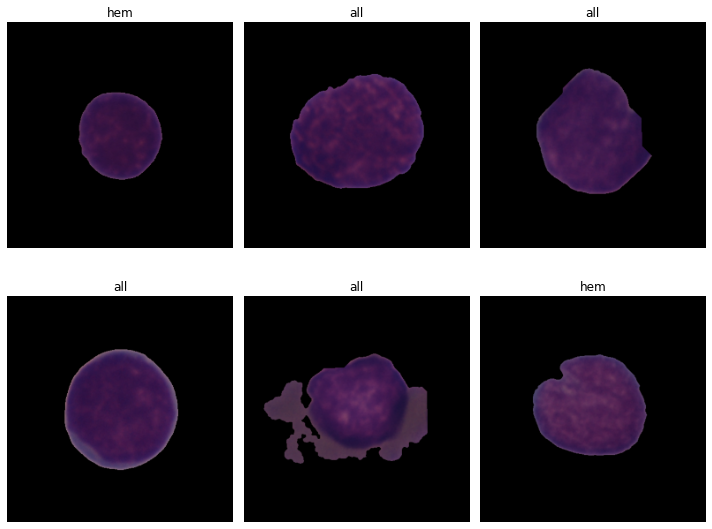

In [ ]:
# Re-Running this cell  will give a assortment of 6 cells that can individually be either normal lymphoblasts (hem) or cancer cells (all)

class_names = data.class_names

plt.figure(figsize=(10, 8))
for images, labels in data.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()

The first objective in exploratory data analysis was to take an average of all all cancer images to compare to an average of all normal lymphoblasts. In python, images are interpreted as matrices that can be plotted as graphs. In essence, an image is just a giant matrix that hold RGB coordinates.  Therefore, to create an average of images we needed to combine all individual matrixes for each image into a single giant matrix. One giant matrix was created for normal cells (called `hem_`) and one for cancerous cells (called `all_`). 

In [ ]:
hem_ = []

for i in glob.glob('/content/drive/Othercomputers/My MacBook Air/BrainStation/Capstone/capstone_data/training_data/hem/*.bmp'):
    im=img.imread(i)
    hem_.append(im)

hem_array = np.array(hem_)

In [ ]:
all_ = []

for i in glob.glob('/content/drive/Othercomputers/My MacBook Air/BrainStation/Capstone/capstone_data/training_data/all/*.bmp'):
    im=img.imread(i)
    all_.append(im)

all_array = np.array(all_)

In [ ]:
hem_array.shape

(3389, 450, 450, 3)

In [ ]:
all_array.shape

(7272, 450, 450, 3)

The shapes of the above arrays reveal that all images in the dataset are 450 pixels by 450 pixels. Assessing the shapes of both aformentioned arrays showcases the distribution of the dataset. As a result these newly created arrays were relatively small, with only 3,389 images being available for our normal cells and 7,272 images being available for our cancer dataset. This imbalance can prove to be an issue during modelling. Data could be manipulated randomly isolating half of ALL images, in order to establish a relatively even number of cells to compare between cancerous and non-cancerous states. Having less data can also prove detrimental to models however. For the purposes of this report, all images were utilized for the sake of comparing both cells. Below are images that are representations of the average of our two classes of cells:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


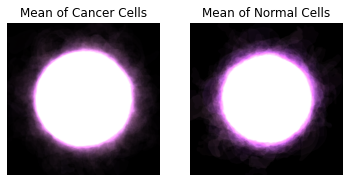

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(all_array.mean(axis=0))
plt.title("Mean of Cancer Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hem_array.mean(axis=0))
plt.title("Mean of Normal Cells")
plt.axis("off")
plt.show()

Already, some interesting observations between both classes of cells can be made. In terms of similarities, the core of both of these images are bright white circles. This makes sense, because all cell images in this dataset have varying presentations of the cell nucleus. Taking the average of over 3000 images cause these variations to cancel each other out, resulting in a uniform colour. In terms of differences, there are two significant observations. Firstly, the average cancer cell looks relatively large compared to the non-cancer image. This makes sense as well, because our understanding of cancer is that neoplastic cells are typically large due to their constant growth, which allows for increased cell division. Secondly, the average cancer cell has a 'thinner' membrane compare to a non-cancer cell. This isn't necessarily a reflection of the thickness in cell membranes, but rather a reflection of average nucleus size. Cancer cells will be significantly more transcriptionally active compared to non-cancer cells, which simply means that there will be more DNA synthesis for eventual protein synthesis. More transcription requires more DNA replication proteins, which takes up space. DNA replication almost exclusively happens in the nucleus, which is why neoplastic cells will almost always have larger nuclei. The result of larger nuclei, represented by the white space in our two images, is that cancer cells will typically have less space between their outer cell membrane and their nuclear envelope. 

Based on these two findings, machine learning models might be able to predict cancerous cells with a high degree of accuracy. Size and thickness of boundaries are two features that are easily discernable by various machine learning models. Furthermore, the high variation in thickness in the normal cell class might also result in a higher representation of colours, which is another feature easily identified by machine learning models. Isolating a small portion of both cells can allow for the comparison of their colour distributions. Comparing a small portion of our two cell stacks will allow for a better representation of the distribution of eosin (pink) colours, without being significantly outweighed by  black and white hues (which obviously make up a majority of the image).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


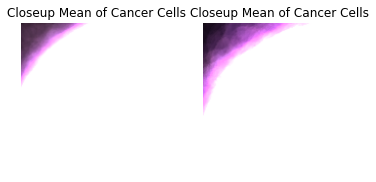

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(all_array[:,100:250,100:250].mean(axis=0))
plt.title("Closeup Mean of Cancer Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hem_array[:,100:250,100:250].mean(axis=0))
plt.title("Closeup Mean of Cancer Cells")
plt.axis("off")
plt.show()

<function matplotlib.pyplot.show>

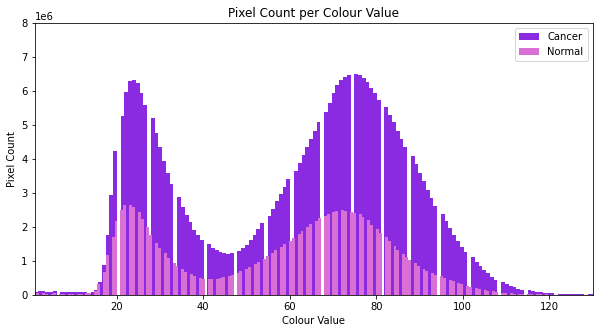

In [ ]:
plt.figure(figsize = (10, 5))
plt.hist(np.ravel(all_array[:,100:250,100:250]), bins=256, label = 'Cancer', color = 'blueviolet')
plt.hist(np.ravel(hem_array[:,100:250,100:250]), bins=256, label = 'Normal', color = 'orchid')
plt.ylim(0,8000000)
plt.xlim(1,130)
plt.xlabel('Colour Value')
plt.ylabel('Pixel Count')
plt.legend(loc='upper right')
plt.title('Pixel Count per Colour Value')
plt.show

The above graph actually showcases a surpising finding, being that the cancer cell somehow showcases a more expansive colour distribution when compared to normal lymphoblasts. This is peculiar, and might require further biological testing to better understand why the thinner cancer cell membrane might be showcasing a larger variation in colour. 

A lot was surmised from the initial exploratory data analysis and this concludes this report. Please proceed to the next report detailing the base model, a sequential convolutional network. 